## Exercises

1. __Sigmoid neurons simulating perceptrons, part I__: Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, $c > 0$. Show that the behaviour of the network doesn't change. 

    `Ans:`
     
    \begin{align*}
        (c \times w) \cdot x + c \times b   &= c \times (w \cdot x) + c \times b \\
                                            &= c \times (w \cdot x + b)
                                            \\
        \text{For a perceptron,} \\
                                    output =& \begin{cases}
                                            0    & w \cdot x + b \leq 0 \\
                                            1    & w \cdot x + b > 0
                                            \end{cases} \\
                                            \\
        \text{When, } w \cdot x + b         &\leq 0 \\
        \text{For some positive constant } c, \\
            c \times (w \cdot x + b)        &\leq 0 \\
                                            \\
        \text{Similarly,} \\
        \text{When, } w \cdot x + b         &> 0 \\
         c \times (w \cdot x + b)           &> 0 \\
    \end{align*}

2. __Sigmoid neurons simulating perceptrons, part II__: Suppose we have the same setup as the last problem - a network of perceptrons. Suppose also that the overall input to the network of perceptrons has been chosen. We won't need the actual input value, we just need the input to have been fixed. Suppose the weights and biases are such that $w \cdot x + b \neq 0$ for the input $x$ to any particular perceptron in the network. Now replace all the perceptrons in the network by sigmoid neurons, and multiply the weights and biases by a positive constant $c > 0$. Show that in the limit as $c \rightarrow \infty$ the behaviour of this network of sigmoid neurons is exactly the same as the network of perceptrons. How can this fail when $w \cdot x + b = 0$ for one of the perceptrons? 

    `Ans:`

    \begin{align*}
        \text{For } w \cdot x + b > 0, \\
        \lim_{c \rightarrow \infty} c \times (w \cdot x + b)    &= +\infty
                                                                \\ \\
        \text{For } w \cdot x + b < 0, \\
        \lim_{c \rightarrow \infty} c \times (w \cdot x + b)    &= -\infty 
                                                                \\ \\
        \text{The output of the sigmoid neuron is given by,} \\
                                                    \sigma      &= \frac{1}{1 + e^{-z}} \quad [z = w \cdot x + b]
                                                                \\ \\
        \text{When, }                       w \cdot x + b       &= +\infty \\
                                                    \sigma      &= \frac{1}{1 + e^{-\infty}} \quad \\
                                                                &= \frac{1}{1 + 0} \quad \\
                                                                &= 1
                                                                \\ \\
        \text{When, }                       w \cdot x + b       &= -\infty \\
                                                    \sigma      &= \frac{1}{1 + e^{\infty}} \quad \\
                                                                &= \frac{1}{\infty} \quad \\
                                                                &= 0
                                                                \\ \\
        \text{When, }                       w \cdot x + b       &= 0 \\
                                                    \sigma      &= \frac{1}{1 + e^{0}} \quad \\
                                                                &= \frac{1}{1 + 1} \quad \\
                                                                &= 0.5 \quad \text{[which is not a valid value for a perceptron]}
    \end{align*}

3. There is a way of determining the bitwise representation of a digit by adding an extra layer to the three-layer network above. The extra layer converts the output from the previous layer into a binary representation, as illustrated in the figure below. Find a set of weights and biases for the new output layer. Assume that the first 3 layers of neurons are such that the correct output in the third layer (i.e., the old output layer) has activation at least 0.99, and incorrect outputs have activation less than 0.01. 

<div style='background-color: #ffffff; display: flex; justify-content: center; padding-bottom: 8px'>
    <img src='other-assets/tikz13.png' />
</div>

`Ans:` Assuming $0.99$ is activation for the correct neuron and $0.009$ is activation for the incorrect neurons.

\begin{align*}
    \text{Weights, }    w^{(O)} &= \begin{bmatrix}
        -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & -0.5 & 0.1 & 0.09 \\
        -0.5 & -0.5 & -0.5 & -0.5 & 0.1 & 0.07 & 0.05 & 0.1 & -0.5 & -0.5 \\
        -0.5 & -0.5 & 0.09 & 0.1 & -0.5 & -0.5 & 0.1 & 0.04 & -0.5 & -0.5 \\
        -0.5 & -0.5 & -0.5 & 0.04 & -0.5 & 0.04 & -0.5 & 0.07 & -0.5 & 0.1         
    \end{bmatrix} 
    \\
    \text{Biases, }     b^{(O)} &= \begin{bmatrix}
        0 & 0 & 0 & 0
    \end{bmatrix}^T
    \\
    \text{Input activations, } a^{(I)} &= \begin{bmatrix}
        a_0^{(I)} & a_1^{(I)} & a_2^{(I)} & a_3^{(I)} & a_4^{(I)} & a_5^{(I)} & a_6^{(I)} & a_7^{(I)} & a_8^{(I)} & a_9^{(I)}
    \end{bmatrix}^T
    \\
        z &= w^{(O)} a^{(I)} + b^{(O)}
    \\
    \text{Output, } O_i &= \begin{cases}
    0   &   \sigma(z_i) < 0.5 \\
    1   &   \sigma(z_i) \geq 0.5 \\
    \end{cases}
\end{align*}

4. An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, x, we update our weights and biases according to the rules $wk \rightarrow w'_{k}=w_k − \eta \frac{\partial C_x}{\partial w_k}$ and $b_l \rightarrow b'_{l}=b_l − \eta \frac{\partial C_x}{\partial b_l}$. Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20. 

    `Ans:`
    
    Advantage: Faster weight updates as new data come.
    
    Disadvantage: Update based on a mini-batch could be noisy resulting into a performance degradation. 

### Notations:

- Weight from $k^{th}$ neuron in the $(l-1)^{th}$ layer to the $j^{th}$ neuron in the $l^{th}$ layer: $w_{jk}^l$
- Bias for the $j^{th}$ neuron in the $l^{th}$: $b_j^l$
- Activation at the $j^{th}$ neuron in $l^{th}$ layer: $a_j^l = \sigma{(\sum_{k} w_{jk}^l a_k^{l-1} + b_j^l)}$

### Matrix Form:
- Weights in the $l^{th}$ layer: $w^l = \begin{bmatrix} 
    w_{00}^l & w_{01}^l & w_{02}^l & \cdots & w_{0k}^l \\
    w_{10}^l & w_{11}^l & w_{12}^l & \cdots & w_{1k}^l \\
    w_{20}^l & w_{21}^l & w_{22}^l & \cdots & w_{2k}^l \\
    \vdots  &   \vdots  &   \vdots  & \ddots  &   \vdots \\
    w_{j0}^l & w_{j1}^l & w_{j2}^l & \cdots & w_{jk}^l \\
\end{bmatrix}_{j \times k}$
- Biases in the $l^{th}$ layer: $b^l = \begin{bmatrix} b_0^l \\ b_1^l \\ b_2^l \\ \vdots \\ b_k^l \end{bmatrix}$
- Activations in the $l^{th}$ layer: $a^l = \sigma(w^l a^{l-1} + b^l)$

### Back Propagation

In neural network, we can directly calculate the gradient of the cost function for just the last layer. To update the weights and biases at the previous layers we use this algorithm called `Back Propagation` which propagates the error backward from last layer. Before calculating the gradient w.r.t the weights ($w$) and biases ($b$), we need to calculate an intermediate quantity $\delta$. 

$\delta$ is the measure of error of the cost function w.r.t the weighted input $z$ ($w^{l} a^{l-1} + b^l$). The form of this error depends on the cost function. For the quadratic cost function (**_MSE_**), $\delta$ at the last layer $L$ is:

\begin{align*}
    \delta_j^L &= \frac{\partial C}{\partial a_j^L} \sigma'(z_j^L) \quad [a_j = \sigma(z_j)] \tag{1}
    \\ \\
    \text{Here,} \\
    \frac{\partial C}{\partial a_j^L} &= \frac{1}{2} \frac{\partial}{\partial a_j^L} (y_j - a_j^L)^2 \\
                                      &= (a_j^L - y_j)
    \\ \\
    \text{So, $\delta_j^L$ can be re-written as, } \\
    \delta_j^L &= (a_j^L - y_j) \sigma'(z_j^L) 
    \\ \\
\end{align*}

Since, $\frac{\partial C}{\partial a^L}$ is the gradient of the cost function w.r.t the activations at the last layer, we can write:

\begin{align*}
    \delta^L &= \nabla_aC \odot \sigma'(z^L) \tag{1a} \\
             &= (a^L - y) \odot \sigma'(z^L)
\end{align*}

$\delta^l$ in terms of the errors at the next layer ($l+1$):

\begin{align*}
    \delta_j^l &= \left(\sum_k w_{kj}^{l+1} \delta_k^{l+1}\right) \sigma'(z_j^l) 
    \\ \\
    \delta^l   &= ({(w^{l+1})}^T \delta^{l+1}) \odot \sigma'(z^l) \tag{2} \\ 
\end{align*}

Gradient of the cost function w.r.t biases ($b$) at any layer:

\begin{align*}
    \frac{\partial C}{\partial b_j^l} &= \delta_j^l \tag{3}
\end{align*}

Gradient of the cost function w.r.t weights ($w$) at any layer:

\begin{align*}
    \frac{\partial C}{\partial w_{jk}^l} &= a_k^{l-1} \delta_j^l  \tag{4}
\end{align*}

## Implementation

In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
from numpy.typing import NDArray, DTypeLike
from typing import Literal, Tuple, List, Optional

MInputDtype = Tuple[NDArray, NDArray]
IndexLikeDType = slice | int | List | np.ndarray

In [4]:
def sigmoid(z: NDArray):
    z = np.clip(z, -709.78, 709.78)
    exp = np.exp(z)
    return exp / (1 + exp)

In [5]:
def sigmoid_prime(z: NDArray):
    return sigmoid(z) * (1.0 - sigmoid(z))

In [6]:
def default_on_none(value, default):
    if value is None:
        return default
    return value

In [7]:

class MNIST_DATASET:
    splits = {'train': 'datasets/mnist-train.parquet', 'test': 'datasets/mnist-test.parquet'}
    
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self._iter_idx = -1
        self._data_cache = dict() 
    
    def clear_cache(self):
        self._data_cache.clear()
    
    def imshow(
        self, 
        index: int, 
        figsize: Tuple[int, int] = (6, 6), 
    ):
        img = self._get_image(index)

        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
        plt.show()
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._iter_idx == len(self) - 1:
            self._iter_idx = -1
            raise StopIteration
    
        self._iter_idx += 1
        return self[self._iter_idx]
    
    def __getitem__(self, index_like: IndexLikeDType) -> MInputDtype:
        if isinstance(index_like, list) or isinstance(index_like, np.ndarray):
            xs, ys = [], []
            for idx in index_like:
                x, y = self._getitem_helper(idx)
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)
        elif isinstance(index_like, slice):
            xs, ys = [], []
            start = default_on_none(index_like.start, 0)
            stop = default_on_none(index_like.stop, len(self))
            step = default_on_none(index_like.step, 1)
            for i in range(start, stop, step):
                x, y = self._getitem_helper(i)
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)
        else:
            return self._getitem_helper(index_like)
        
    def _getitem_helper(self, index: int) -> MInputDtype:
        cached_data = self._data_cache.get(index)
        if cached_data is not None:
            return cached_data
        
        img = self._get_image(index)
        img = self._normalize(img)
        img = np.expand_dims(img.ravel(), axis=1)
        
        label = self.df.loc[index]['label']
        y_vec = np.zeros((10, 1), dtype=np.float64)
        y_vec[label][0] = 1.0
    
        self._data_cache[index] = (img, y_vec) 
        return self._data_cache[index]
        
    def __len__(self) -> int:
        return len(self.df)
    
    def _get_image(self, index: int):
        return np.array(Image.open(BytesIO(self.df.loc[index]['image']['bytes'])), np.uint8)
    
    def _normalize(self, img: NDArray, dtype: DTypeLike = np.float64):
        return (img / 255.0).astype(dtype)
    
    @staticmethod
    def get_split(split: Literal['train', 'test']):
        return MNIST_DATASET(pd.read_parquet(MNIST_DATASET.splits[split]))
    

In [8]:
class Network:
    def __init__(self, layer_sizes: List[int]):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        
        self.biases = [np.zeros((y, 1)) for y in layer_sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        
    def SGD(
            self,
            train_dataset: MNIST_DATASET,
            batch_size: int,
            epoch: int,
            lr: float,
            test_dataset: Optional[MNIST_DATASET] = None 
        ):
        epoch_width = int(np.log10(epoch) + 1)
        n_steps = len(train_dataset) // batch_size
        step_width = int(np.log10(n_steps) + 1)
        test_set_width = -1 if test_dataset is None else int(np.log10(len(test_dataset)) + 1)
        
        for i in range(epoch):
            step_count = 0
            random_indices = np.random.permutation(len(train_dataset))
            for j in range(0, len(train_dataset), batch_size):
                if j + batch_size > len(train_dataset):
                    break
                
                step_count += 1
                indices = random_indices[j: j + batch_size]
                data = train_dataset[indices]
                self._update_mini_batch(data, lr) 
                sys.stdout.write(f'\rEpoch {i + 1:>{epoch_width}}: {step_count:>{step_width}} / {n_steps}')
                
            if test_dataset is not None:
                sys.stdout.write(f' | Test result: {self.evaluate(test_dataset[:]):>{test_set_width}} / {len(test_dataset)}\n') 
            else:
                sys.stdout.write('\n')

    def feedforward(self, activation: NDArray):
        for weight, bias in zip(self.weights, self.biases):
            activation = sigmoid((weight @ activation) + bias)
        return activation
    
    def evaluate(self, data: MInputDtype):
        x, y = data
        y_pred = self.feedforward(x) 
        return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
    
    def _update_mini_batch(self, batch: MInputDtype, lr: float):
        x, y = batch
        nabla_b, nabla_w = self._back_propagate(x, y)
        for i in range(self.n_layers - 1):
            self.biases[i] -= (lr * nabla_b[i])
            self.weights[i] -= (lr * nabla_w[i])
        
    def _back_propagate(self, x: NDArray, y: NDArray):
        zs = []
        activation, activations = x, [x]
        nabla_b = []
        nabla_w = []
        
        for weight, bias in zip(self.weights, self.biases):
            z = (weight @ activation) + bias
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        delta = self._compute_cost_derivative(activation, y) * sigmoid_prime(zs[-1])
        nabla_b.append(np.mean(delta, axis=0))
        nabla_w.append(np.mean(delta @ activations[-2].transpose(0, 2, 1), axis=0))
        
        for l in range(2, self.n_layers):
            delta = (self.weights[-l + 1].T @ delta) * sigmoid_prime(zs[-l])
            nabla_b.append(np.mean(delta, axis=0))
            nabla_w.append(np.mean(delta @ activations[-l - 1].transpose(0, 2, 1), axis=0))
            
        return (nabla_b[::-1], nabla_w[::-1])
        
    def _compute_cost_derivative(self, a_L: NDArray, y: NDArray):
        return a_L - y


In [9]:
train_dataset = MNIST_DATASET.get_split('train')
test_dataset = MNIST_DATASET.get_split('test')

In [10]:
net = Network([784, 32, 10])
net.SGD(
    train_dataset=train_dataset, 
    batch_size=16, 
    lr=0.7,
    epoch=20, 
    test_dataset=test_dataset
)

Epoch  1: 3750 / 3750 | Test result:  8229 / 10000
Epoch  2: 3750 / 3750 | Test result:  8735 / 10000
Epoch  3: 3750 / 3750 | Test result:  8937 / 10000
Epoch  4: 3750 / 3750 | Test result:  9018 / 10000
Epoch  5: 3750 / 3750 | Test result:  9079 / 10000
Epoch  6: 3750 / 3750 | Test result:  9117 / 10000
Epoch  7: 3750 / 3750 | Test result:  9151 / 10000
Epoch  8: 3750 / 3750 | Test result:  9186 / 10000
Epoch  9: 3750 / 3750 | Test result:  9207 / 10000
Epoch 10: 3750 / 3750 | Test result:  9219 / 10000
Epoch 11: 3750 / 3750 | Test result:  9238 / 10000
Epoch 12: 3750 / 3750 | Test result:  9261 / 10000
Epoch 13: 3750 / 3750 | Test result:  9270 / 10000
Epoch 14: 3750 / 3750 | Test result:  9286 / 10000
Epoch 15: 3750 / 3750 | Test result:  9317 / 10000
Epoch 16: 3750 / 3750 | Test result:  9300 / 10000
Epoch 17: 3750 / 3750 | Test result:  9317 / 10000
Epoch 18: 3750 / 3750 | Test result:  9317 / 10000
Epoch 19: 3750 / 3750 | Test result:  9332 / 10000
Epoch 20: 3750 / 3750 | Test re

Ground truth: 9, Prediction: 9


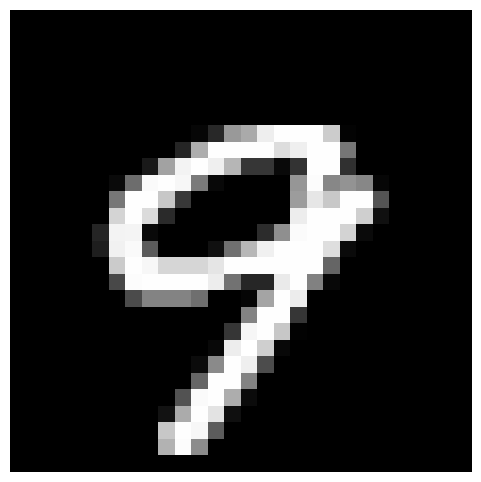

In [11]:
idx = np.random.randint(0, len(test_dataset))
x, y = test_dataset[idx]
gt = np.argmax(y)
pred = np.argmax(net.feedforward(x)) 

print(f'Ground truth: {gt}, Prediction: {pred}')
test_dataset.imshow(idx)